In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import cv2

@dataclass
class Config:
    root: str = "/content/drive/MyDrive/LithoBench/eda_6stage_features_errors_MetalSet.csv"  # <-- change to your path
    folders: Tuple[str, ...] = ("litho", "pixelILT", "printed", "resist", "target")

    # binary vs gray stages
    binary_stages: Tuple[str, ...] = ("target", "pixelILT", "printed")
    gray_stages: Tuple[str, ...] = ("litho", "resist")

    thresholds: Tuple[float, ...] = (0.30, 0.40, 0.50)

    # Morph cleanup kernel size (set 0 to disable)
    morph_k: int = 3

    out_csv: str = "eda_6stage_features_errors.csv"


CFG = Config()


#File indexing (filename-based matching)
def list_files(folder: Path) -> Dict[str, Path]:
    return {p.name: p for p in folder.iterdir() if p.is_file()}


def build_index(cfg: Config) -> Tuple[Dict[str, Dict[str, Path]], List[str]]:
    root = Path(cfg.root)
    if not root.exists():
        raise FileNotFoundError(f"Root not found: {root.resolve()}")

    maps: Dict[str, Dict[str, Path]] = {}
    for f in cfg.folders:
        fp = root / f
        if not fp.exists():
            raise FileNotFoundError(f"Missing folder: {fp.resolve()}")
        maps[f] = list_files(fp)

    common = set(maps[cfg.folders[0]].keys())
    for f in cfg.folders[1:]:
        common &= set(maps[f].keys())
    common = sorted(common)

    if len(common) == 0:
        raise RuntimeError("No common filenames across all 6 folders.")

    # quick report
    for f in cfg.folders:
        miss = sorted(set(common) - set(maps[f].keys()))
        extra = sorted(set(maps[f].keys()) - set(common))
        if miss:
            print(f"[WARN] {f}: missing {len(miss)} (first 5): {miss[:5]}")
        if extra:
            print(f"[INFO] {f}: extra {len(extra)} (first 5): {extra[:5]}")

    print(f"[OK] common masks = {len(common)}")
    return maps, common


#Robust loader (png/jpg + npy)
def load_as_float01(path: Path) -> np.ndarray:
    suf = path.suffix.lower()
    if suf == ".npy":
        arr = np.load(path)
        arr = np.asarray(arr)
        if arr.ndim == 3:
            arr = arr.mean(axis=-1)
        arr = arr.astype(np.float32)
        mn, mx = float(arr.min()), float(arr.max())
        if mx - mn < 1e-8:
            return np.zeros_like(arr, dtype=np.float32)
        return (arr - mn) / (mx - mn)

    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    return img.astype(np.float32) / 255.0


# Part 3) Binarization + cleanup
def otsu_binarize(img01: np.ndarray, auto_invert: bool = True) -> np.ndarray:
    img8 = np.clip(img01 * 255.0, 0, 255).astype(np.uint8)
    blur = cv2.GaussianBlur(img8, (5, 5), 0)
    _, b = cv2.threshold(blur, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b.astype(np.uint8)


def threshold_binarize(img01: np.ndarray, thr: float, auto_invert: bool = True) -> np.ndarray:
    b = (img01 > thr).astype(np.uint8)
    if auto_invert and b.mean() > 0.5:
        b = 1 - b
    return b


def cleanup_binary(bin01: np.ndarray, k: int) -> np.ndarray:
    if k is None or k <= 0:
        return bin01.astype(np.uint8)
    kernel = np.ones((k, k), np.uint8)
    x = cv2.morphologyEx(bin01.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, kernel)
    return x.astype(np.uint8)


#Target feature extraction (geometry / complexity)
def perimeter_px(bin01: np.ndarray) -> int:
    edge = cv2.Canny((bin01 * 255).astype(np.uint8), 50, 150)
    return int((edge > 0).sum())


def count_components(bin01: np.ndarray) -> int:
    num, _ = cv2.connectedComponents((bin01 > 0).astype(np.uint8), connectivity=4)
    return int(num - 1)


def extract_target_features(target_bin: np.ndarray) -> Dict[str, float]:
    area_frac = float(target_bin.mean())
    perim = float(perimeter_px(target_bin))
    comps = float(count_components(target_bin))
    area = float(target_bin.sum()) + 1e-6
    compact = float((perim * perim) / area)
    edge = cv2.Canny((target_bin * 255).astype(np.uint8), 50, 150)
    edge_density = float((edge > 0).mean())

    return {
        "target_area_frac": area_frac,
        "target_perimeter": perim,
        "target_components": comps,
        "target_compactness": compact,
        "target_edge_density": edge_density,
    }


#Error metrics (IoU / XOR / component delta)
def iou(a: np.ndarray, b: np.ndarray) -> float:
    a = (a > 0)
    b = (b > 0)
    inter = np.logical_and(a, b).sum()
    uni = np.logical_or(a, b).sum()
    return float(inter / (uni + 1e-8))


def xor_rate(a: np.ndarray, b: np.ndarray) -> float:
    a = (a > 0)
    b = (b > 0)
    x = np.logical_xor(a, b).sum()
    uni = np.logical_or(a, b).sum()
    return float(x / (uni + 1e-8))


def comp_delta(a: np.ndarray, b: np.ndarray) -> int:
    return int(count_components(b) - count_components(a))

#Optional alignment sanity check (centroid shift)
def centroid_xy(bin01: np.ndarray) -> Tuple[float, float]:
    ys, xs = np.where(bin01 > 0)
    if len(xs) == 0:
        return (np.nan, np.nan)
    return float(xs.mean()), float(ys.mean())


def centroid_shift(a: np.ndarray, b: np.ndarray) -> float:
    ax, ay = centroid_xy(a)
    bx, by = centroid_xy(b)
    if np.isnan(ax) or np.isnan(bx):
        return float("nan")
    return float(np.sqrt((ax - bx) ** 2 + (ay - by) ** 2))


#Process one mask (load -> preprocess -> features/errors)
def process_one(name: str, maps: Dict[str, Dict[str, Path]], cfg: Config) -> Dict[str, float]:
    # Load float01
    imgs = {st: load_as_float01(maps[st][name]) for st in cfg.folders}

    # Binarize binary-stages (Otsu)
    bins = {}
    for st in cfg.binary_stages:
        b = otsu_binarize(imgs[st], auto_invert=True)
        b = cleanup_binary(b, cfg.morph_k)
        bins[st] = b

    # Gray stages -> multi-threshold bins
    gray_bins: Dict[str, Dict[float, np.ndarray]] = {}
    for st in cfg.gray_stages:
        gray_bins[st] = {}
        for t in cfg.thresholds:
            b = threshold_binarize(imgs[st], float(t), auto_invert=True)
            b = cleanup_binary(b, cfg.morph_k)
            gray_bins[st][float(t)] = b

    # Row: id + target features
    row: Dict[str, float] = {"mask_name": name}
    row.update(extract_target_features(bins["target"]))

    # Alignment sanity: target vs printed
    row["shift_target_printed"] = centroid_shift(bins["target"], bins["printed"])

    # --- Stage-wise: target vs (glp, pixelILT, printed)
    # row["iou_target_glp"] = iou(bins["target"], bins["glp"])
    # row["xor_target_glp"] = xor_rate(bins["target"], bins["glp"])

    row["iou_target_pixelILT"] = iou(bins["target"], bins["pixelILT"])
    row["xor_target_pixelILT"] = xor_rate(bins["target"], bins["pixelILT"])

    row["iou_target_printed"] = iou(bins["target"], bins["printed"])
    row["xor_target_printed"] = xor_rate(bins["target"], bins["printed"])
    row["comp_delta_target_printed"] = comp_delta(bins["target"], bins["printed"])

    # --- Stage-wise: (glp or pixelILT) -> litho -> resist -> printed (threshold별)
    # glp -> litho
    for t in cfg.thresholds:
        lt = gray_bins["litho"][float(t)]
        # row[f"iou_glp_litho_t{t:.2f}"] = iou(bins["glp"], lt)
        # row[f"xor_glp_litho_t{t:.2f}"] = xor_rate(bins["glp"], lt)

        row[f"iou_pixelILT_litho_t{t:.2f}"] = iou(bins["pixelILT"], lt)
        row[f"xor_pixelILT_litho_t{t:.2f}"] = xor_rate(bins["pixelILT"], lt)

    # litho -> resist
    for t in cfg.thresholds:
        lt = gray_bins["litho"][float(t)]
        rt = gray_bins["resist"][float(t)]
        row[f"iou_litho_resist_t{t:.2f}"] = iou(lt, rt)
        row[f"xor_litho_resist_t{t:.2f}"] = xor_rate(lt, rt)

    # resist -> printed
    for t in cfg.thresholds:
        rt = gray_bins["resist"][float(t)]
        row[f"iou_resist_printed_t{t:.2f}"] = iou(rt, bins["printed"])
        row[f"xor_resist_printed_t{t:.2f}"] = xor_rate(rt, bins["printed"])
        row[f"comp_delta_resist_printed_t{t:.2f}"] = comp_delta(rt, bins["printed"])

    # Threshold stability summary (resist->printed)
    rp_ious = [row[f"iou_resist_printed_t{t:.2f}"] for t in cfg.thresholds]
    row["iou_resist_printed_mean"] = float(np.mean(rp_ious))
    row["iou_resist_printed_std"] = float(np.std(rp_ious))

    return row


def run(cfg: Config) -> pd.DataFrame:
    maps, common = build_index(cfg)

    rows = []
    for i, name in enumerate(common, 1):
        try:
            rows.append(process_one(name, maps, cfg))
        except Exception as e:
            print(f"[ERROR] {name}: {e}")

        if i % 50 == 0 or i == len(common):
            print(f"Processed {i}/{len(common)}")

    df = pd.DataFrame(rows)
    df.to_csv(cfg.out_csv, index=False, encoding="utf-8-sig")
    print(f"[DONE] Saved {cfg.out_csv} | rows={len(df)} cols={df.shape[1]}")
    return df


if __name__ == "__main__":
    df = run(CFG)
    print(df.head(3).to_string(index=False))

FileNotFoundError: Missing folder: /content/drive/MyDrive/LithoBench/eda_6stage_features_errors_MetalSet.csv/litho

df shape: (16422, 35)


,mask_name,target_area_frac,target_perimeter,target_components,target_compactness,target_edge_density,shift_target_printed,iou_target_pixelILT,xor_target_pixelILT,iou_target_printed,...,xor_resist_printed_t0.30,comp_delta_resist_printed_t0.30,iou_resist_printed_t0.40,xor_resist_printed_t0.40,comp_delta_resist_printed_t0.40,iou_resist_printed_t0.50,xor_resist_printed_t0.50,comp_delta_resist_printed_t0.50,iou_resist_printed_mean,iou_resist_printed_std
0,cell0.png,0.032221,3816.0,5.0,107.749071,0.000910,7.253800,0.277372,0.722628,0.874213,...,0.127952,0,0.936504,0.063496,0,1.0,0.0,0,0.936184,0.052237
1,cell1.png,0.021050,2488.0,4.0,70.110702,0.000593,3.550673,0.252697,0.747303,0.897977,...,0.115562,0,0.943578,0.056422,0,1.0,0.0,0,0.942672,0.047182
2,cell10.png,0.023471,3182.0,5.0,102.851611,0.000759,2.892827,0.238871,0.761129,0.888228,...,0.137473,0,0.931286,0.068714,0,1.0,0.0,0,0.931271,0.056123
3,cell100.png,0.030795,4306.0,7.0,143.550002,0.001027,8.126874,0.289927,0.710073,0.851242,...,0.141747,0,0.929795,0.070205,0,1.0,0.0,0,0.929349,0.057869
4,cell1000.png,0.025963,3300.0,4.0,100.001837,0.000787,2.883656,0.239703,0.760297,0.879492,...,0.133199,0,0.934217,0.065783,0,1.0,0.0,0,0.933673,0.054380



[NA count top]
mask_name                    0
target_area_frac             0
target_perimeter             0
target_components            0
target_compactness           0
target_edge_density          0
shift_target_printed         0
iou_target_pixelILT          0
xor_target_pixelILT          0
iou_target_printed           0
xor_target_printed           0
comp_delta_target_printed    0
iou_pixelILT_litho_t0.30     0
xor_pixelILT_litho_t0.30     0
iou_pixelILT_litho_t0.40     0
xor_pixelILT_litho_t0.40     0
iou_pixelILT_litho_t0.50     0
xor_pixelILT_litho_t0.50     0
iou_litho_resist_t0.30       0
xor_litho_resist_t0.30       0
dtype: int64

[Describe]


,count,mean,std,min,25%,50%,75%,max
target_area_frac,16422.0,2.616368e-02,0.012648,0.003377,0.017437,0.024166,0.032082,0.080854
target_perimeter,16422.0,3.401761e+03,1526.294623,494.000000,2318.000000,3166.000000,4163.500000,10190.000000
target_components,16422.0,4.002192e+00,1.404099,1.000000,3.000000,4.000000,5.000000,12.000000
target_compactness,16422.0,1.061054e+02,44.866324,17.228097,73.192952,99.663341,129.892285,340.822068
target_edge_density,16422.0,8.110430e-04,0.000364,0.000118,0.000553,0.000755,0.000993,0.002429
shift_target_printed,16422.0,5.193206e+00,3.414303,0.072007,2.861541,4.510029,6.622491,30.680448
iou_target_pixelILT,16422.0,2.503020e-01,0.067906,0.094198,0.204689,0.244097,0.283306,0.518547
xor_target_pixelILT,16422.0,7.496980e-01,0.067906,0.481453,0.716694,0.755903,0.795311,0.905802
iou_target_printed,16422.0,8.860917e-01,0.020142,0.764328,0.874028,0.887716,0.899575,0.956285
xor_target_printed,16422.0,1.139083e-01,0.020142,0.043715,0.100425,0.112284,0.125972,0.235672



After dropna: (16422, 9)


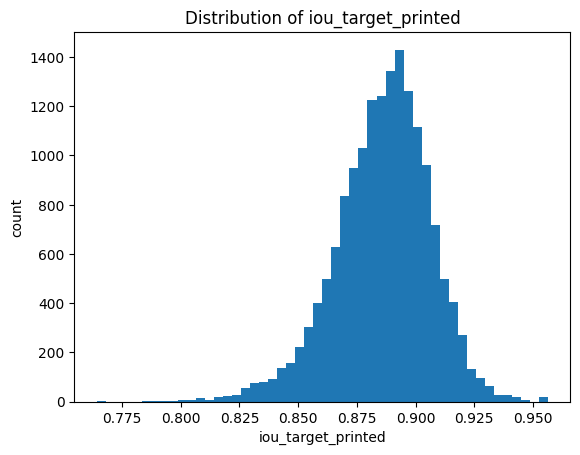

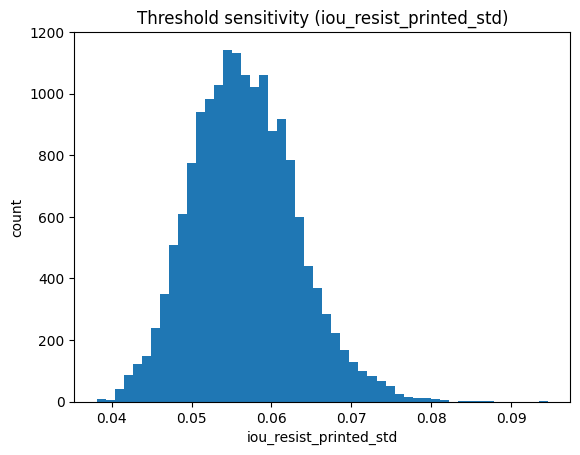

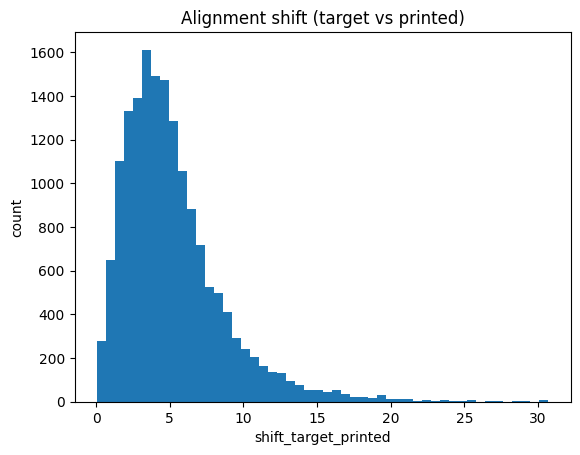

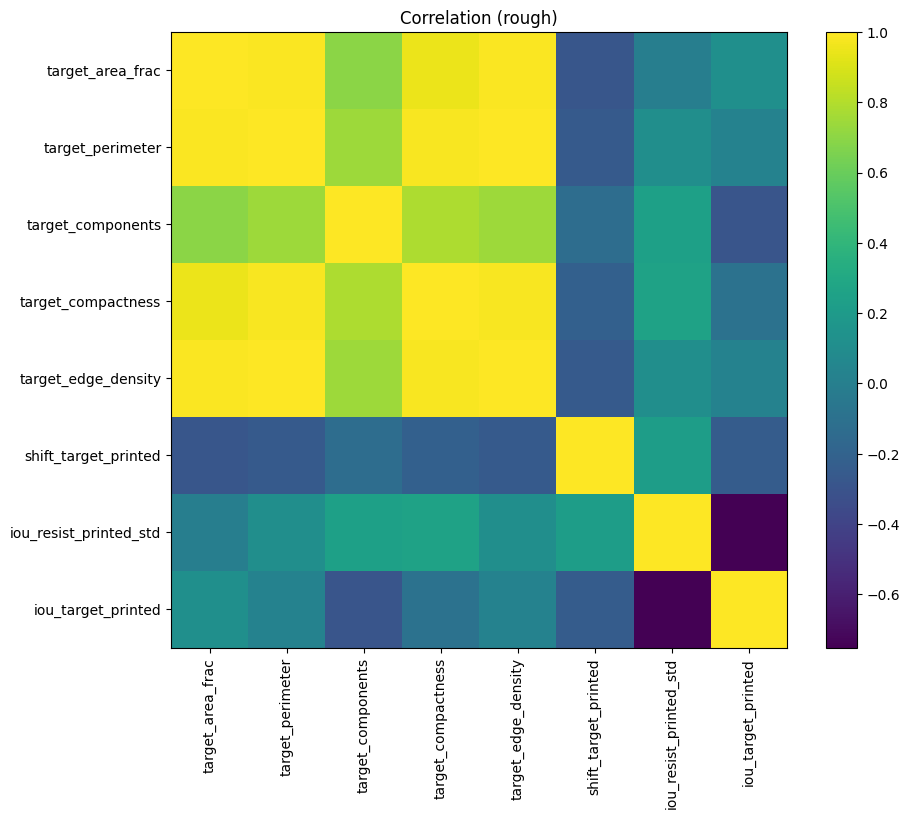


Filter cutoff std <= 0.06790258950837985
filtered shape: (15600, 10)

[OLS Robust HC3 - BASE]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     4609.
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:44:17   Log-Likelihood:                 12154.
No. Observations:               16422   AIC:                        -2.429e+04
Df Residuals:                   16415   BIC:                        -2.424e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     3526.
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:44:17   Log-Likelihood:                 11602.
No. Observations:               15600   AIC:                        -2.319e+04
Df Residuals:                   15593   BIC:                        -2.314e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '



[Bootstrap CI - BASE]


,term,coef_mean,ci2.5,ci97.5,n_boot_ok
0,const,3.462426e+00,3.433144e+00,3.495620e+00,300
1,target_area_frac,1.042931e+02,9.550433e+01,1.139184e+02,300
2,target_perimeter,-1.608456e-03,-1.766351e-03,-1.467803e-03,300
3,target_components,-7.269161e-02,-7.522985e-02,-7.069984e-02,300
4,target_compactness,2.820477e-02,2.586644e-02,3.085307e-02,300
5,target_edge_density,-3.836593e-10,-4.215443e-10,-3.501367e-10,300
6,shift_target_printed,-2.795926e-03,-3.484108e-03,-2.205012e-03,300
7,iou_resist_printed_std,-2.363863e+01,-2.423206e+01,-2.305888e+01,300



[Bootstrap CI - FILTERED]


,term,coef_mean,ci2.5,ci97.5,n_boot_ok
0,const,3.476253e+00,3.443763e+00,3.509380e+00,300
1,target_area_frac,1.055902e+02,9.463996e+01,1.177387e+02,300
2,target_perimeter,-1.640606e-03,-1.829731e-03,-1.469046e-03,300
3,target_components,-7.239863e-02,-7.505078e-02,-6.995878e-02,300
4,target_compactness,2.898900e-02,2.617474e-02,3.207549e-02,300
5,target_edge_density,-3.914517e-10,-4.365733e-10,-3.503571e-10,300
6,shift_target_printed,-3.404218e-03,-4.004593e-03,-2.891423e-03,300
7,iou_resist_printed_std,-2.398248e+01,-2.461523e+01,-2.332999e+01,300



[Bootstrap CI - WLS]


,term,coef_mean,ci2.5,ci97.5,n_boot_ok
0,const,3.448928e+00,3.416926e+00,3.479618e+00,300
1,target_area_frac,1.055950e+02,9.440795e+01,1.168545e+02,300
2,target_perimeter,-1.625258e-03,-1.803718e-03,-1.448902e-03,300
3,target_components,-7.311759e-02,-7.561956e-02,-7.084024e-02,300
4,target_compactness,2.848339e-02,2.545128e-02,3.152213e-02,300
5,target_edge_density,-3.876948e-10,-4.304021e-10,-3.456020e-10,300
6,shift_target_printed,-2.820139e-03,-3.434302e-03,-2.156030e-03,300
7,iou_resist_printed_std,-2.348138e+01,-2.410754e+01,-2.284457e+01,300



Bad ratio: 0.0

[Logistic Regression for bad-pattern (interpretation)]


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                16422
Model:                          Logit   Df Residuals:                    16415
Method:                           MLE   Df Model:                            6
Date:                Tue, 27 Jan 2026   Pseudo R-squ.:                     inf
Time:                        10:44:39   Log-Likelihood:            -2.4713e-05
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -20.5378   3647.928     -0.006      0.996   -7170.344    7129.269
target_area_frac           0.0063   1.87e+06   3.36e-09      1.000   -3.66e+06    3.66e+06
targ

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive cla


CV AUC=nan | PR-AUC=0.000

[Permutation tests: bad vs good mean-diff]


,feature,mean_diff(bad-good),p_perm
0,target_area_frac,NaN,0.0005
1,target_perimeter,NaN,0.0005
2,target_components,NaN,0.0005
3,target_compactness,NaN,0.0005
4,target_edge_density,NaN,0.0005
5,shift_target_printed,NaN,0.0005
6,iou_resist_printed_std,NaN,0.0005



comp_delta has negatives?  True  | using delta_abs as count target
delta_abs mean: 0.00505419559127999 var: 0.005028956931120871

[Poisson seems ok]
                 Generalized Linear Model Regression Results                  
Dep. Variable:              delta_abs   No. Observations:                16422
Model:                            GLM   Df Residuals:                    16415
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -384.29
Date:                Tue, 27 Jan 2026   Deviance:                       602.58
Time:                        10:44:44   Pearson chi2:                 6.24e+04
No. Iterations:                     9   Pseudo R-squ. (CS):            0.01662
Covariance Type:            nonrobust                                         
                             coef    std err          z     

In [ ]:
# =========================================
# Step 7-8: EDA + Inference + Validation
# =========================================
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# statsmodels (Colab에 보통 있음)
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score, r2_score, mean_absolute_error

CSV_PATH = "/content/drive/MyDrive/LithoBench/eda_6stage_features_errors_MetalSet.csv"  # CFG.out_csv
df = pd.read_csv(CSV_PATH)

print("df shape:", df.shape)
display(df.head())

# -------------------------
# 1) 기본 EDA: 결측/기초통계
# -------------------------
print("\n[NA count top]")
na = df.isna().sum().sort_values(ascending=False)
print(na.head(20))

print("\n[Describe]")
display(df.describe(include="number").T)

# 우리가 관심 있는 X(feature) & Y(target) 지정
X_cols = [
    "target_area_frac",
    "target_perimeter",
    "target_components",
    "target_compactness",
    "target_edge_density",
    "shift_target_printed",
    "iou_resist_printed_std",   # 측정 불안정성(민감도)
]
Y_reg = "iou_target_printed"   # 회귀 타깃(원하면 다른 IoU/XOR로 바꿔도 됨)

# 숫자 컬럼만 남기고 dropna
use_cols = list(dict.fromkeys(["mask_name"] + X_cols + [Y_reg]))
d = df[use_cols].copy()
d = d.dropna()
print("\nAfter dropna:", d.shape)

# -------------------------
# 2) 분포 확인(EDA)
# -------------------------
def hist_plot(series, title):
    plt.figure()
    plt.hist(series.values, bins=50)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("count")
    plt.show()

hist_plot(d[Y_reg], f"Distribution of {Y_reg}")
hist_plot(d["iou_resist_printed_std"], "Threshold sensitivity (iou_resist_printed_std)")
hist_plot(d["shift_target_printed"], "Alignment shift (target vs printed)")

# 간단 상관(스케일/분포 영향은 있음; 참고용)
corr = d[X_cols + [Y_reg]].corr(numeric_only=True)
plt.figure(figsize=(10,8))
plt.imshow(corr.values)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation (rough)")
plt.colorbar()
plt.show()

# -------------------------
# 3) IoU/XOR 같은 [0,1] 비율형 타깃 -> logit 변환
#    (0이나 1이면 무한대가 되므로 clip)
# -------------------------
def logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

d["y_logit"] = logit(d[Y_reg])

# -------------------------
# 4) 측정 불안정(std) 처리 옵션
#    A) 필터: std가 큰 상위 q% 제거
#    B) 가중치: w = 1/(std + eps)
# -------------------------
FILTER_Q = 0.95  # 상위 5% 불안정 샘플 제거(원하면 0.90 등으로)
eps = 1e-6

cut = d["iou_resist_printed_std"].quantile(FILTER_Q)
d_filt = d[d["iou_resist_printed_std"] <= cut].copy()

d_w = d.copy()
d_w["w"] = 1.0 / (d_w["iou_resist_printed_std"].values + eps)

print("\nFilter cutoff std <=", cut)
print("filtered shape:", d_filt.shape)

# -------------------------
# 5) 추론(해석) 중심: OLS + robust SE(HC3)
#    y_logit ~ features
# -------------------------
def fit_ols_robust(df_in, y_col="y_logit", x_cols=X_cols):
    X = df_in[x_cols].copy()
    X = sm.add_constant(X, has_constant="add")
    y = df_in[y_col].astype(float).values
    model = sm.OLS(y, X).fit(cov_type="HC3")  # 이분산 robust
    return model

m_base = fit_ols_robust(d)
m_filt = fit_ols_robust(d_filt)

print("\n[OLS Robust HC3 - BASE]")
print(m_base.summary())

print("\n[OLS Robust HC3 - FILTERED by std]")
print(m_filt.summary())

# 가중회귀(WLS) 버전도 같이
def fit_wls_robust(df_in, y_col="y_logit", x_cols=X_cols, w_col="w"):
    X = df_in[x_cols].copy()
    X = sm.add_constant(X, has_constant="add")
    y = df_in[y_col].astype(float).values
    w = df_in[w_col].astype(float).values
    model = sm.WLS(y, X, weights=w).fit(cov_type="HC3")
    return model

m_wls = fit_wls_robust(d_w)
print("\n[WLS (weight=1/std) Robust HC3]")
print(m_wls.summary())

# -------------------------
# 6) 부트스트랩으로 계수 CI (추론 안정성)
# -------------------------
def bootstrap_coef_ci(df_in, fit_fn, B=300, seed=0):
    rng = np.random.default_rng(seed)
    coefs = []
    n = len(df_in)
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        sample = df_in.iloc[idx]
        try:
            m = fit_fn(sample)
            coefs.append(m.params.values)
        except Exception:
            continue
    coefs = np.array(coefs)
    cols = fit_fn(df_in).params.index.tolist()
    out = pd.DataFrame({
        "term": cols,
        "coef_mean": coefs.mean(axis=0),
        "ci2.5": np.quantile(coefs, 0.025, axis=0),
        "ci97.5": np.quantile(coefs, 0.975, axis=0),
        "n_boot_ok": len(coefs)
    })
    return out

boot_base = bootstrap_coef_ci(d, lambda s: fit_ols_robust(s), B=300, seed=1)
boot_filt = bootstrap_coef_ci(d_filt, lambda s: fit_ols_robust(s), B=300, seed=2)
boot_wls  = bootstrap_coef_ci(d_w, lambda s: fit_wls_robust(s), B=300, seed=3)

print("\n[Bootstrap CI - BASE]")
display(boot_base)

print("\n[Bootstrap CI - FILTERED]")
display(boot_filt)

print("\n[Bootstrap CI - WLS]")
display(boot_wls)

# -------------------------
# 7) “좋은 vs 나쁜 샘플” 분류 + 퍼뮤테이션 테스트(가정 적게)
#    예: iou_target_printed < 0.7 이면 bad
# -------------------------
THR_BAD = 0.70
d2 = d.copy()
d2["is_bad"] = (d2[Y_reg] < THR_BAD).astype(int)

print("\nBad ratio:", d2["is_bad"].mean())

# 로지스틱 회귀(해석가능한 분류기)
X = sm.add_constant(d2[X_cols], has_constant="add")
y = d2["is_bad"].values
logit_m = sm.Logit(y, X).fit(disp=False)

print("\n[Logistic Regression for bad-pattern (interpretation)]")
print(logit_m.summary())

# 분류 성능은 교차검증으로(예측 목적)
def cv_auc_pr(df_in, x_cols=X_cols, y_col="is_bad", k=5, seed=0):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    aucs, prs = [], []
    Xall = df_in[x_cols].values
    yall = df_in[y_col].values
    for tr, te in kf.split(Xall):
        Xtr = sm.add_constant(Xall[tr], has_constant="add")
        Xte = sm.add_constant(Xall[te], has_constant="add")
        m = sm.Logit(yall[tr], Xtr).fit(disp=False)
        p = m.predict(Xte)
        aucs.append(roc_auc_score(yall[te], p))
        prs.append(average_precision_score(yall[te], p))
    return float(np.mean(aucs)), float(np.mean(prs))

auc, pr = cv_auc_pr(d2)
print(f"\nCV AUC={auc:.3f} | PR-AUC={pr:.3f}")

# 퍼뮤테이션 테스트: 좋은/나쁜 그룹 간 feature 평균 차이가 우연인지
def permutation_test_mean_diff(df_in, feature, label="is_bad", B=2000, seed=0):
    rng = np.random.default_rng(seed)
    x = df_in[feature].values
    y = df_in[label].values
    obs = x[y==1].mean() - x[y==0].mean()
    cnt = 0
    for _ in range(B):
        yp = rng.permutation(y)
        diff = x[yp==1].mean() - x[yp==0].mean()
        if abs(diff) >= abs(obs):
            cnt += 1
    p = (cnt + 1) / (B + 1)
    return obs, p

print("\n[Permutation tests: bad vs good mean-diff]")
perm_results = []
for f in X_cols:
    obs, p = permutation_test_mean_diff(d2, f, B=2000, seed=1)
    perm_results.append((f, obs, p))
perm_df = pd.DataFrame(perm_results, columns=["feature", "mean_diff(bad-good)", "p_perm"])
display(perm_df.sort_values("p_perm"))

# -------------------------
# 8) comp_delta 모델링(정수형): Poisson vs NegBin 자동
# -------------------------
# 예시 타깃: printed의 컴포넌트 변화
Y_cnt = "comp_delta_target_printed"
if Y_cnt in df.columns:
    dc = df[["mask_name"] + X_cols + [Y_cnt]].dropna().copy()
    # 음수도 가능해서(printed가 더 적으면 음수), count모델은 그대로 못 씀
    # 해결1) 절대값/양수변환을 타깃으로 잡기
    # 해결2) "결함 발생 여부"(delta!=0) 이진으로 모델링
    dc["delta_abs"] = np.abs(dc[Y_cnt].values)

    print("\ncomp_delta has negatives? ", (dc[Y_cnt] < 0).any(), " | using delta_abs as count target")

    # 과산포 체크: var >> mean이면 NegBin 고려
    mean_c = dc["delta_abs"].mean()
    var_c = dc["delta_abs"].var()
    print("delta_abs mean:", mean_c, "var:", var_c)

    # GLM Poisson
    Xc = sm.add_constant(dc[X_cols], has_constant="add")
    pois = sm.GLM(dc["delta_abs"], Xc, family=sm.families.Poisson()).fit()

    # 간단 과산포 기준
    overdisp = var_c > 1.5 * mean_c
    if overdisp:
        nb = sm.GLM(dc["delta_abs"], Xc, family=sm.families.NegativeBinomial(alpha=1.0)).fit()
        print("\n[NegBin chosen due to overdispersion]")
        print(nb.summary())
    else:
        print("\n[Poisson seems ok]")
        print(pois.summary())

else:
    print("\nNo comp_delta_target_printed column found - skip count modeling.")

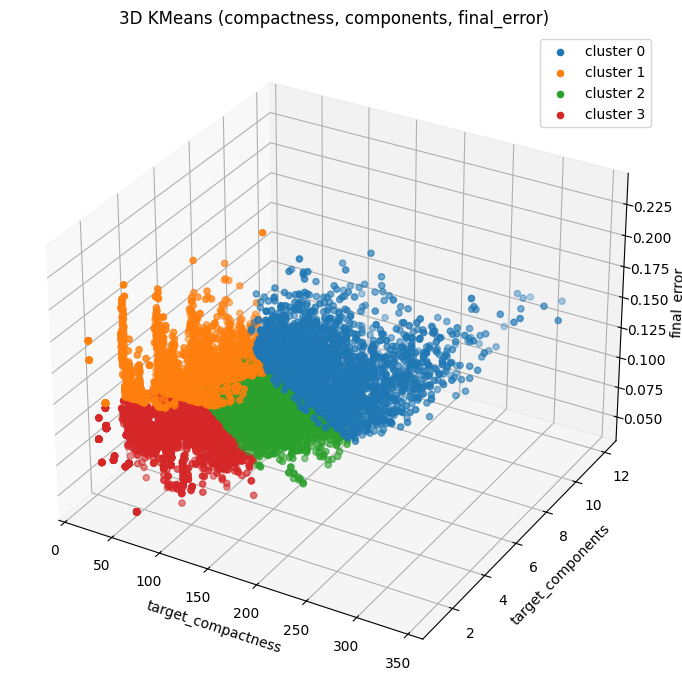

,cluster,n,final_error_mean,final_error_median,compactness_mean,components_mean
0,0,2797,0.129208,0.128788,171.975585,6.016804
1,1,3339,0.133802,0.130117,73.651570,3.309674
2,2,5510,0.108427,0.109042,119.514495,4.516697
3,3,4776,0.097365,0.098774,74.748581,2.712940


In [ ]:
# 3D KMeans clustering: (compactness, components, final_error)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ----------------------------
# 0) 준비: final_error 없으면 만들기
# ----------------------------
if "final_error" not in df.columns:
    if "iou_target_printed" in df.columns:
        df["final_error"] = 1.0 - df["iou_target_printed"]
    else:
        raise KeyError("df에 'final_error'도 없고, 'iou_target_printed'도 없어서 final_error를 만들 수 없습니다.")

# ----------------------------
# 1) 사용할 3개 변수 (area_frac → target_components)
# ----------------------------
cols = ["target_compactness", "target_components", "final_error"]
missing = [c for c in cols if c not in df.columns]
if missing:
    raise KeyError(f"df에 필요한 컬럼이 없습니다: {missing}")

X = df[cols].replace([np.inf, -np.inf], np.nan).dropna().copy()

# ----------------------------
# 2) 표준화 + KMeans
# ----------------------------
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

K = 4
km = KMeans(n_clusters=K, random_state=0, n_init=10)
labels = km.fit_predict(Xz)

# 원본 df에도 클러스터 라벨 붙이기
df.loc[X.index, "kmeans3d_cluster"] = labels

# ----------------------------
# 3) 3D 산점도
# ----------------------------
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

for k in range(K):
    idx = (labels == k)
    ax.scatter(
        X.loc[idx, "target_compactness"].values,
        X.loc[idx, "target_components"].values,
        X.loc[idx, "final_error"].values,
        s=20,
        label=f"cluster {k}"
    )

ax.set_xlabel("target_compactness")
ax.set_ylabel("target_components")
ax.set_zlabel("final_error")
ax.set_title("3D KMeans (compactness, components, final_error)")
ax.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 4) 클러스터 요약표
# ----------------------------
summary3d = (
    X.assign(cluster=labels)
     .groupby("cluster")
     .agg(
        n=("cluster", "size"),
        final_error_mean=("final_error", "mean"),
        final_error_median=("final_error", "median"),
        compactness_mean=("target_compactness", "mean"),
        components_mean=("target_components", "mean"),
     )
     .reset_index()
)

display(summary3d)

[resist->printed IoU cols] {'t0.30': 'iou_resist_printed_t0.30', 't0.40': 'iou_resist_printed_t0.40', 't0.50': 'iou_resist_printed_t0.50'}
[litho->resist   IoU cols] {'t0.30': 'iou_litho_resist_t0.30', 't0.40': 'iou_litho_resist_t0.40', 't0.50': 'iou_litho_resist_t0.50'}


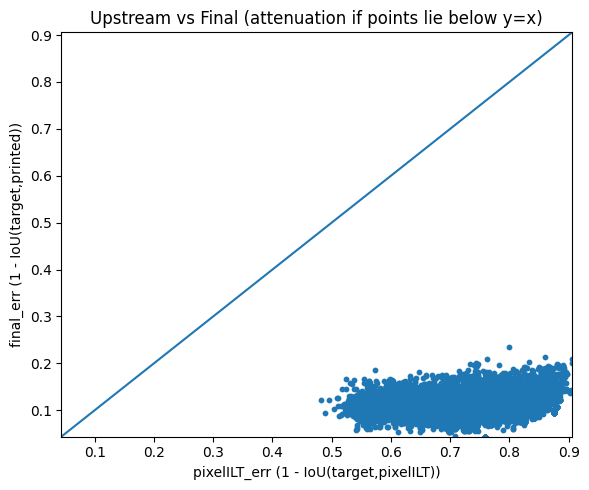

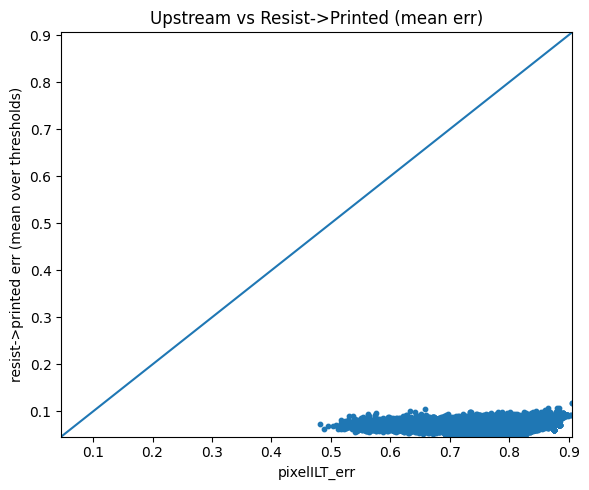

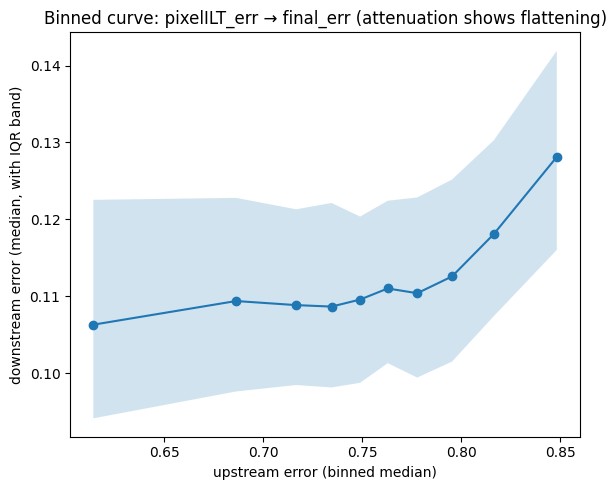

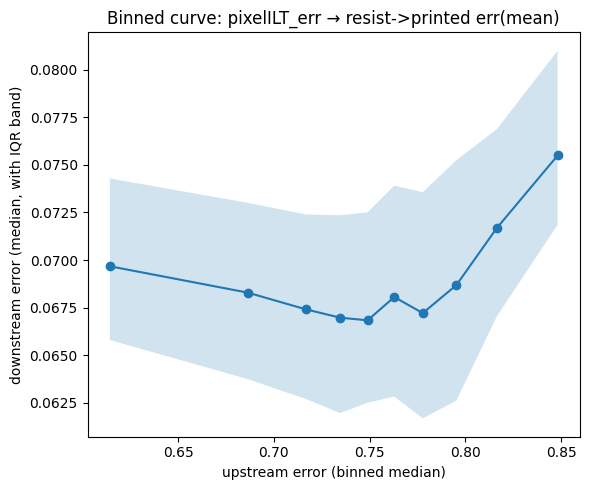


[Saturation: resist_printed_t0.30] n=16422
  frac(IoU >= 0.95) = 0.0000
  frac(IoU >= 0.98) = 0.0000
  frac(IoU >= 0.99) = 0.0000
  frac(IoU >= 0.995) = 0.0000
  frac(IoU >= 0.999) = 0.0000
  median=0.862025, p90=0.880894, p99=0.894386

[Saturation: resist_printed_t0.40] n=16422
  frac(IoU >= 0.95) = 0.0030
  frac(IoU >= 0.98) = 0.0000
  frac(IoU >= 0.99) = 0.0000
  frac(IoU >= 0.995) = 0.0000
  frac(IoU >= 0.999) = 0.0000
  median=0.930768, p90=0.940888, p99=0.948262

[Saturation: resist_printed_t0.50] n=16422
  frac(IoU >= 0.95) = 1.0000
  frac(IoU >= 0.98) = 1.0000
  frac(IoU >= 0.99) = 1.0000
  frac(IoU >= 0.995) = 1.0000
  frac(IoU >= 0.999) = 1.0000
  median=1.000000, p90=1.000000, p99=1.000000


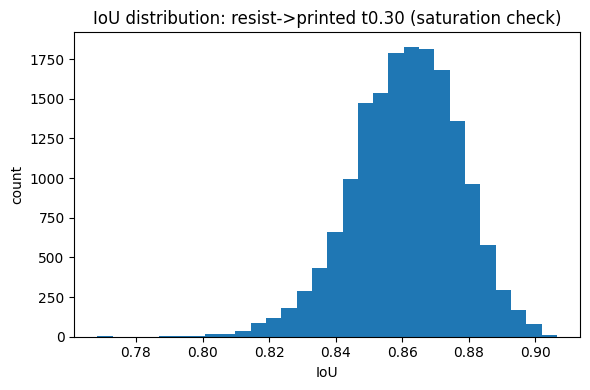

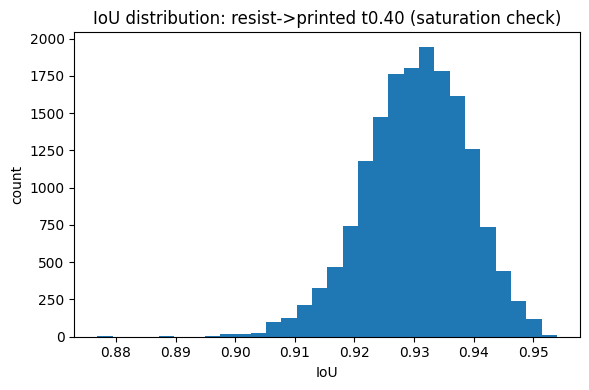

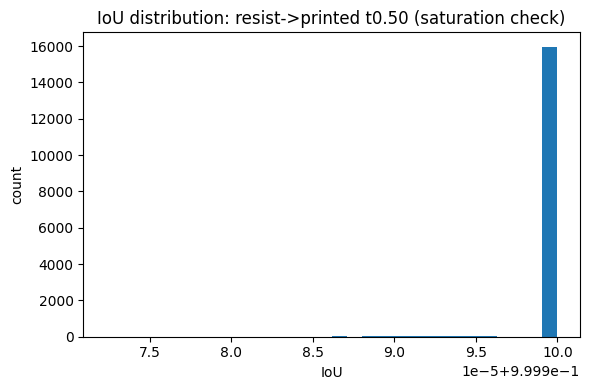

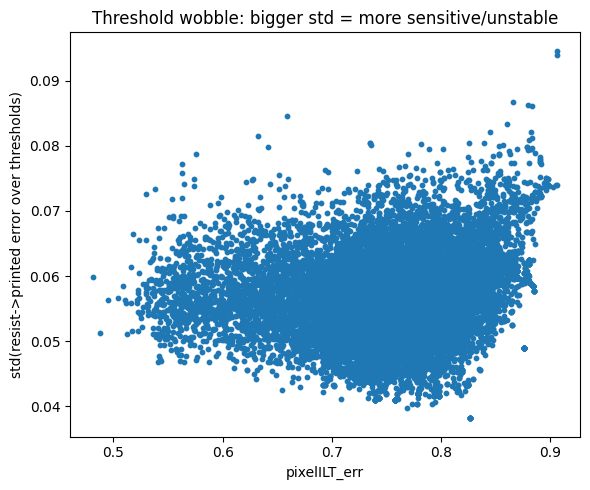

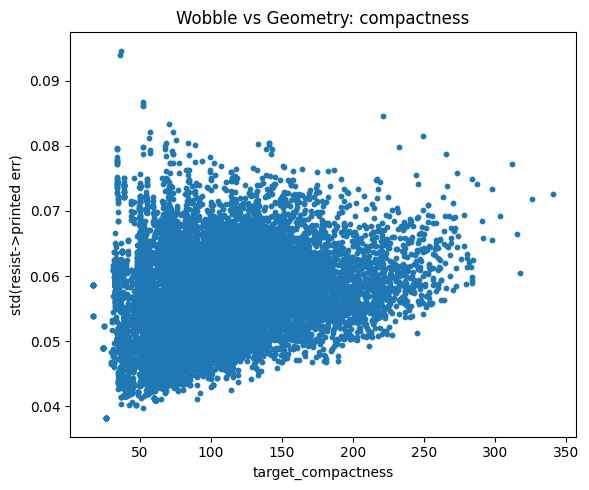

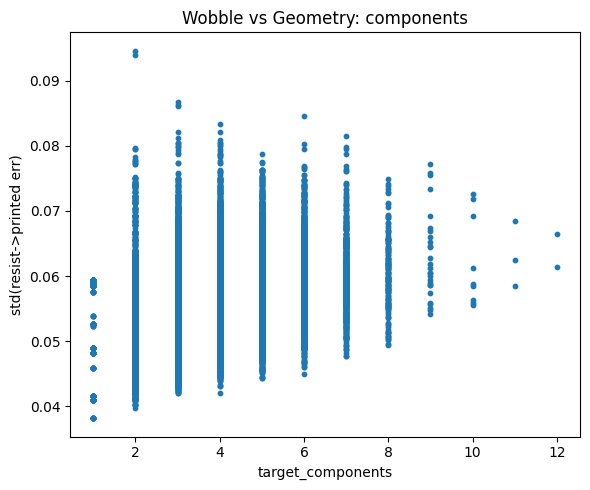

corr(IoU t0.30, t0.40) = 0.9973
corr(IoU t0.30, t0.50) = 0.0254
corr(IoU t0.40, t0.50) = 0.0269


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# df는 이미 로드되어 있다고 가정
# df = pd.read_csv("/content/drive/MyDrive/LithoBench/eda_6stage_features_errors_MetalSet.csv")

# ----------------------------
# 0) 유틸: IoU 컬럼 찾기
# ----------------------------
def require_cols(df, cols):
    miss = [c for c in cols if c not in df.columns]
    if miss:
        raise KeyError(f"필요 컬럼 없음: {miss}")

def iou_to_err(s):
    s = s.replace([np.inf, -np.inf], np.nan)
    return 1.0 - s

def get_iou_cols_by_prefix(df, prefix):
    return sorted([c for c in df.columns if c.startswith(prefix)])

def pick_iou_cols_thresholds(df, prefix, thresholds=("t0.30","t0.40","t0.50")):
    cols = get_iou_cols_by_prefix(df, prefix)
    out = {}
    for t in thresholds:
        cand = [c for c in cols if t in c]
        if cand:
            out[t] = cand[0]
    return out  # dict: {"t0.30": col, ...}

# ----------------------------
# 1) 우리가 볼 Stage 정의
# ----------------------------
# upstream (원인 후보)
require_cols(df, ["iou_target_pixelILT", "iou_target_printed"])
df["pixelILT_err"] = iou_to_err(df["iou_target_pixelILT"])
df["final_err"]    = iou_to_err(df["iou_target_printed"])

# downstream(임계값 영향 보는 구간)
rp_iou_cols = pick_iou_cols_thresholds(df, "iou_resist_printed_", thresholds=("t0.30","t0.40","t0.50"))
lr_iou_cols = pick_iou_cols_thresholds(df, "iou_litho_resist_", thresholds=("t0.30","t0.40","t0.50"))

print("[resist->printed IoU cols]", rp_iou_cols)
print("[litho->resist   IoU cols]", lr_iou_cols)

# resist->printed threshold별 error + wobble(std)
for t, col in rp_iou_cols.items():
    df[f"rp_err_{t}"] = iou_to_err(df[col])

if len(rp_iou_cols) >= 2:
    rp_err_mat = np.vstack([df[f"rp_err_{t}"].values for t in rp_iou_cols.keys()]).T
    df["rp_err_mean"] = np.nanmean(rp_err_mat, axis=1)
    df["rp_err_std"]  = np.nanstd(rp_err_mat, axis=1)
else:
    df["rp_err_mean"] = np.nan
    df["rp_err_std"]  = np.nan

# litho->resist threshold별 error + wobble(std) (가능하면)
for t, col in lr_iou_cols.items():
    df[f"lr_err_{t}"] = iou_to_err(df[col])

if len(lr_iou_cols) >= 2:
    lr_err_mat = np.vstack([df[f"lr_err_{t}"].values for t in lr_iou_cols.keys()]).T
    df["lr_err_mean"] = np.nanmean(lr_err_mat, axis=1)
    df["lr_err_std"]  = np.nanstd(lr_err_mat, axis=1)
else:
    df["lr_err_mean"] = np.nan
    df["lr_err_std"]  = np.nan

# ----------------------------
# 2) (A) "오차를 변형/완화" 시각화 ①: Scatter + y=x
# ----------------------------
def scatter_with_diag(x, y, xlabel, ylabel, title):
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    plt.figure(figsize=(6,5))
    plt.scatter(x, y, s=10)
    lim = (min(np.min(x), np.min(y)), max(np.max(x), np.max(y)))
    plt.plot(lim, lim)  # y=x
    plt.xlim(lim); plt.ylim(lim)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# upstream pixelILT_err → downstream(final_err)
scatter_with_diag(
    df["pixelILT_err"].values, df["final_err"].values,
    "pixelILT_err (1 - IoU(target,pixelILT))", "final_err (1 - IoU(target,printed))",
    "Upstream vs Final (attenuation if points lie below y=x)"
)

# upstream pixelILT_err → resist->printed mean error (threshold 평균)
if np.isfinite(df["rp_err_mean"]).any():
    scatter_with_diag(
        df["pixelILT_err"].values, df["rp_err_mean"].values,
        "pixelILT_err", "resist->printed err (mean over thresholds)",
        "Upstream vs Resist->Printed (mean err)"
    )

# ----------------------------
# 3) (A) "오차를 변형/완화" 시각화 ②: 업스트림을 binning해서 다운스트림 median 곡선
#     → '압축(attenuation)'이면 upstream 증가 대비 downstream 증가가 둔화됨
# ----------------------------
def binned_median_curve(x, y, bins=10, title=""):
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    qs = np.quantile(x, np.linspace(0,1,bins+1))
    xm, ym, yq25, yq75 = [], [], [], []
    for i in range(bins):
        lo, hi = qs[i], qs[i+1]
        idx = (x >= lo) & (x <= hi if i==bins-1 else x < hi)
        if idx.sum() < 5:
            continue
        xb = np.median(x[idx])
        yb = np.median(y[idx])
        xm.append(xb); ym.append(yb)
        yq25.append(np.quantile(y[idx], 0.25))
        yq75.append(np.quantile(y[idx], 0.75))

    plt.figure(figsize=(6,5))
    plt.plot(xm, ym, marker="o")
    plt.fill_between(xm, yq25, yq75, alpha=0.2)
    plt.xlabel("upstream error (binned median)")
    plt.ylabel("downstream error (median, with IQR band)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

binned_median_curve(
    df["pixelILT_err"].values, df["final_err"].values, bins=10,
    title="Binned curve: pixelILT_err → final_err (attenuation shows flattening)"
)

if np.isfinite(df["rp_err_mean"]).any():
    binned_median_curve(
        df["pixelILT_err"].values, df["rp_err_mean"].values, bins=10,
        title="Binned curve: pixelILT_err → resist->printed err(mean)"
    )

# ----------------------------
# 4) (B) "포화(saturation)" 계산 + 히스토그램
#     → IoU가 1 근처로 몰리면 포화
# ----------------------------
def saturation_report(iou_series, name, thr=(0.95, 0.98, 0.99, 0.995, 0.999)):
    s = iou_series.replace([np.inf, -np.inf], np.nan).dropna().values
    print(f"\n[Saturation: {name}] n={len(s)}")
    for t in thr:
        print(f"  frac(IoU >= {t}) = {np.mean(s >= t):.4f}")
    print(f"  median={np.median(s):.6f}, p90={np.quantile(s,0.9):.6f}, p99={np.quantile(s,0.99):.6f}")

# resist->printed t0.50 같은 게 1에 붙어있으면 포화가 강하게 나타남
for t, col in rp_iou_cols.items():
    saturation_report(df[col], f"resist_printed_{t}")

# 히스토그램(포화 모양 시각화)
for t, col in rp_iou_cols.items():
    s = df[col].replace([np.inf, -np.inf], np.nan).dropna().values
    plt.figure(figsize=(6,4))
    plt.hist(s, bins=30)
    plt.title(f"IoU distribution: resist->printed {t} (saturation check)")
    plt.xlabel("IoU"); plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# ----------------------------
# 5) (C) "threshold에 따라 흔들림(wobble)" 시각화
#     → std가 클수록 threshold에 민감 = 공정 조건 바뀌면 결과 변동 큼
# ----------------------------
if np.isfinite(df["rp_err_std"]).any():
    # wobble vs upstream
    plt.figure(figsize=(6,5))
    plt.scatter(df["pixelILT_err"], df["rp_err_std"], s=10)
    plt.xlabel("pixelILT_err")
    plt.ylabel("std(resist->printed error over thresholds)")
    plt.title("Threshold wobble: bigger std = more sensitive/unstable")
    plt.tight_layout()
    plt.show()

    # wobble vs geometry (예: compactness, components)
    if "target_compactness" in df.columns and "target_components" in df.columns:
        plt.figure(figsize=(6,5))
        plt.scatter(df["target_compactness"], df["rp_err_std"], s=10)
        plt.xlabel("target_compactness")
        plt.ylabel("std(resist->printed err)")
        plt.title("Wobble vs Geometry: compactness")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(6,5))
        plt.scatter(df["target_components"], df["rp_err_std"], s=10)
        plt.xlabel("target_components")
        plt.ylabel("std(resist->printed err)")
        plt.title("Wobble vs Geometry: components")
        plt.tight_layout()
        plt.show()

# threshold별 결과가 서로 얼마나 다른지(상관)도 확인
if len(rp_iou_cols) >= 2:
    keys = list(rp_iou_cols.keys())
    for i in range(len(keys)):
        for j in range(i+1, len(keys)):
            a, b = keys[i], keys[j]
            ca, cb = rp_iou_cols[a], rp_iou_cols[b]
            x = df[ca].replace([np.inf, -np.inf], np.nan)
            y = df[cb].replace([np.inf, -np.inf], np.nan)
            m = x.notna() & y.notna()
            if m.sum() > 10:
                r = np.corrcoef(x[m], y[m])[0,1]
                print(f"corr(IoU {a}, {b}) = {r:.4f}")

사용 공정 IoU:
- pixelILT: iou_target_pixelILT
- pixelILT_litho: iou_pixelILT_litho_t0.40
- litho_resist: iou_litho_resist_t0.40
- resist_printed: iou_resist_printed_mean

공정: pixelILT


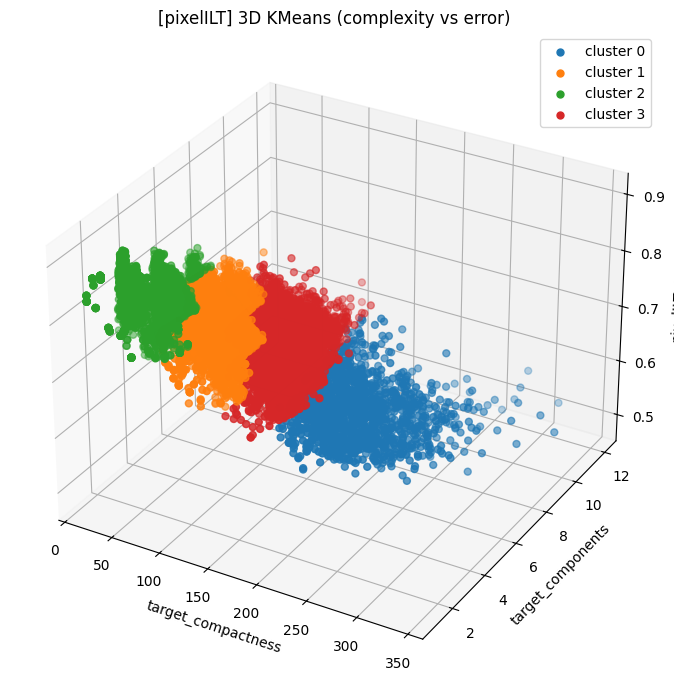

,cluster,n,err_mean,err_median,err_p90,compactness_mean,components_mean
0,2,4267,0.819234,0.818131,0.863041,58.816569,2.479728
1,1,6411,0.761327,0.760627,0.801135,95.891247,3.753549
2,3,4273,0.712812,0.714886,0.754702,135.144524,5.205476
3,0,1471,0.604458,0.608079,0.655401,203.440351,6.006798



공정: pixelILT_litho


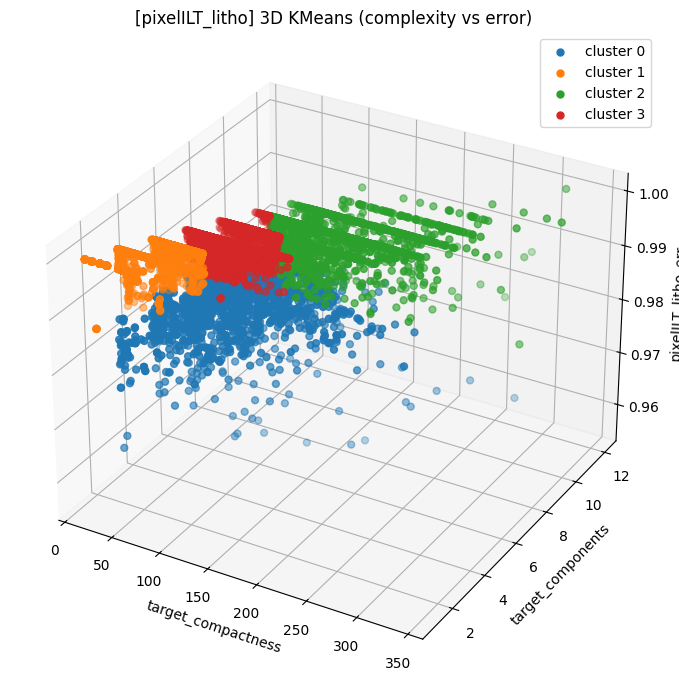

,cluster,n,err_mean,err_median,err_p90,compactness_mean,components_mean
0,1,5081,0.999560,1.000000,1.000000,65.264322,2.526078
1,2,3065,0.999094,1.000000,1.000000,172.848401,5.891680
2,3,6637,0.999654,1.000000,1.000000,107.949110,4.153232
3,0,1639,0.986310,0.987231,0.991466,100.436719,4.433191



공정: litho_resist


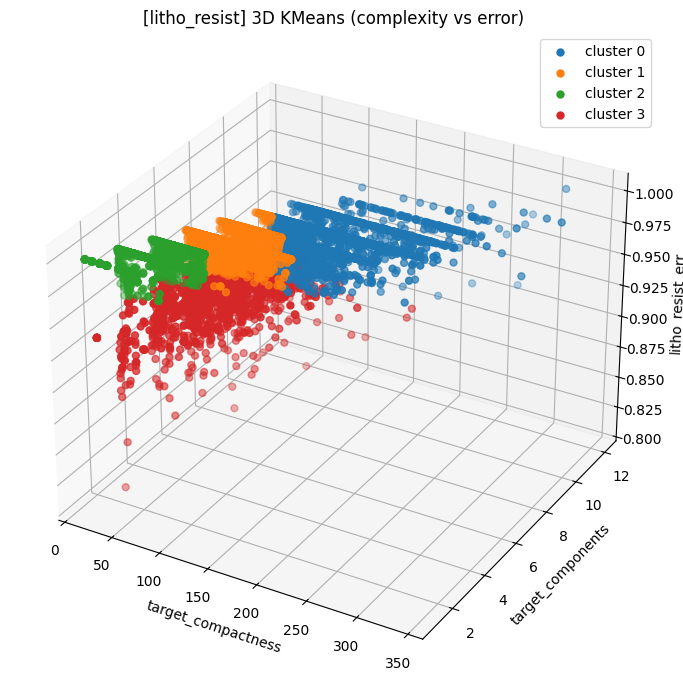

,cluster,n,err_mean,err_median,err_p90,compactness_mean,components_mean
0,0,3128,0.996041,1.000000,1.000000,173.481907,5.926471
1,1,6718,0.998562,1.000000,1.000000,108.712578,4.183983
2,2,5107,0.998437,1.000000,1.000000,65.929061,2.533973
3,3,1469,0.949585,0.953855,0.969854,90.388138,4.177672



공정: resist_printed


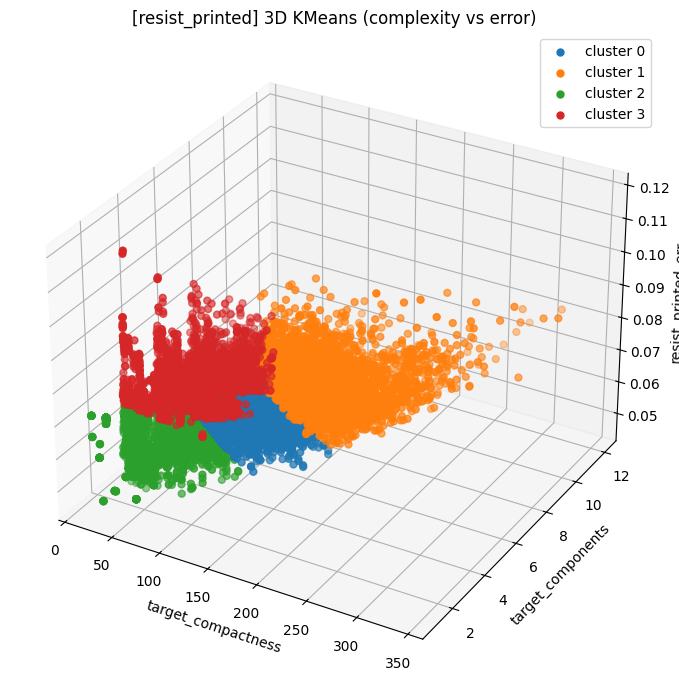

,cluster,n,err_mean,err_median,err_p90,compactness_mean,components_mean
0,3,3736,0.077755,0.076592,0.085463,82.957712,3.265257
1,1,3229,0.074699,0.074299,0.083363,171.667865,5.864664
2,0,5300,0.066761,0.066885,0.072381,112.932923,4.429245
3,2,4157,0.061569,0.061630,0.068365,67.277449,2.673322


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# =========================
# 1) 기본 축 (패턴 복잡도)
# =========================
X_COL = "target_compactness"
Y_COL = "target_components"

assert X_COL in df.columns
assert Y_COL in df.columns

# =========================
# 2) 공정별 IoU 컬럼 자동 선택
# =========================
def pick_prefer(df_cols, prefix, prefer="t0.40"):
    cands = [c for c in df_cols if c.startswith(prefix)]
    if not cands:
        return None
    pref = [c for c in cands if prefer in c]
    return sorted(pref)[0] if pref else sorted(cands)[0]

stage_iou = {}

if "iou_target_pixelILT" in df.columns:
    stage_iou["pixelILT"] = "iou_target_pixelILT"

if "iou_pixelILT_litho_t0.40" in df.columns:
    stage_iou["pixelILT_litho"] = "iou_pixelILT_litho_t0.40"

if "iou_litho_resist_t0.40" in df.columns:
    stage_iou["litho_resist"] = "iou_litho_resist_t0.40"

if "iou_resist_printed_mean" in df.columns:
    stage_iou["resist_printed"] = "iou_resist_printed_mean"

print("사용 공정 IoU:")
for k, v in stage_iou.items():
    print(f"- {k}: {v}")

# =========================
# 3) 공정별 KMeans + 시각화
# =========================
def run_stage_kmeans(stage, iou_col, K=4):
    err_col = f"{stage}_err"
    df[err_col] = 1.0 - df[iou_col]

    use = df[[X_COL, Y_COL, err_col]].replace([np.inf, -np.inf], np.nan).dropna()

    if len(use) < K:
        print(f"[SKIP] {stage}: 데이터 부족")
        return

    # 표준화
    Xz = StandardScaler().fit_transform(use)

    km = KMeans(n_clusters=K, random_state=0, n_init=20)
    labels = km.fit_predict(Xz)

    # ---------- 3D Plot ----------
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection="3d")

    for k in range(K):
        idx = labels == k
        ax.scatter(
            use.loc[idx, X_COL],
            use.loc[idx, Y_COL],
            use.loc[idx, err_col],
            s=25,
            label=f"cluster {k}"
        )

    ax.set_xlabel(X_COL)
    ax.set_ylabel(Y_COL)
    ax.set_zlabel(err_col)
    ax.set_title(f"[{stage}] 3D KMeans (complexity vs error)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ---------- 요약 ----------
    summary = (
        use.assign(cluster=labels)
           .groupby("cluster")
           .agg(
               n=("cluster", "size"),
               err_mean=(err_col, "mean"),
               err_median=(err_col, "median"),
               err_p90=(err_col, lambda s: float(np.quantile(s, 0.9))),
               compactness_mean=(X_COL, "mean"),
               components_mean=(Y_COL, "mean"),
           )
           .sort_values("err_median", ascending=False)
           .reset_index()
    )

    display(summary)

# =========================
# 4) 전체 공정 실행
# =========================
for stage, iou_col in stage_iou.items():
    print(f"\n==============================")
    print(f"공정: {stage}")
    print(f"==============================")
    run_stage_kmeans(stage, iou_col)